In [1]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize
from math import sin

In [2]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


In [3]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners]
        return payment.round(2)

Use case of FirstPriceAuction

In [4]:
# advertisers' fixed parameters
###advertisers are unknwon and the number might have to change
n_adv = 4 # four advertisers
#ctrs might to change depending on time
ctrs = np.array([0.8, 0.65, 0.50, 0.75])#profit per click on the ad
#v might to change depending on time what is v ?
v = np.array([0.7, 1.1, 1.4, 0.85])

# environmental settings will change
n_users= 3

auction = FirstPriceAuction(ctrs=ctrs)
for u in range(n_users):
    print(f'# User {u}')
    bids = np.random.choice([0.25, 0.5, 0.75, 1], size=n_adv) ### may have to chosse a sequence instead, like sin for exemple
    pub_values = bids*ctrs
    print(f'Bids: {bids}, Publisher Values: {pub_values}')
    winner, payment_per_click = auction.round(bids=bids)
    print(f'Auction Winner: {winner}, Payment-per-click: {payment_per_click}')
    print(f'Payment == Bid : {payment_per_click == bids[winner]}')

# User 0
Bids: [1.   0.25 0.25 0.75], Publisher Values: [0.8    0.1625 0.125  0.5625]
Auction Winner: 0, Payment-per-click: 1.0
Payment == Bid : True
# User 1
Bids: [1.  0.5 1.  0.5], Publisher Values: [0.8   0.325 0.5   0.375]
Auction Winner: 0, Payment-per-click: 1.0
Payment == Bid : True
# User 2
Bids: [0.75 0.25 0.5  0.75], Publisher Values: [0.6    0.1625 0.25   0.5625]
Auction Winner: 0, Payment-per-click: 0.75
Payment == Bid : True


See if it's useful later

In [6]:
n_advertisers = 3 #will have to change
n_users = 1000 #number of round, 
B = 50 #budget will have to see how we choose it
my_valuation = 0.6 #used in c
rho = B/n_users
### the maximum among k uniformly distributed r.v.s is a beta r.v. with alpha=k and beta=1
available_bids = np.linspace(0,1,11)
win_probabilities = stats.beta.cdf(available_bids, n_advertisers, 1)

Pattern definition

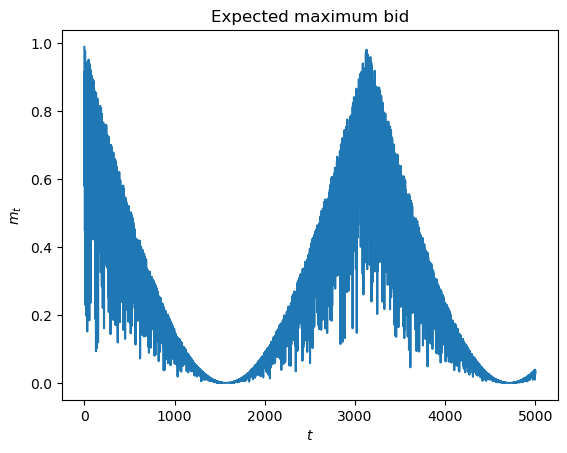

In [17]:
### Adversarial Bidders
#### interest !!
n_advertisers = 3
n_users = 5000
B = 300
my_valuation = 0.6 #used in c
rho = B/n_users

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 1-np.abs(np.sin(5*t/n_users))
other_bids = np.array([np.random.uniform(0, pattern(t), size = n_advertisers) for t in range(n_users)]).T
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

m_t = other_bids.max(axis=0)

plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

Saving this for an eventual use in the future

In [18]:
available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])
## Linear Program
#linprog is a wayto optimize the function and the bid
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

### Generalized Multiplicative Pacing for Non-Truthful Auctions

#### Here, we will assume a **full-feedback** setting. In auctions, full-feedback is equivalent of knowing the maximum bid $m_t$ that won the auction (of course, **after** the auction). Moreover, bids will be **discretized** into a finite set of actions.
Full feedback = You know th bid of each competitor

#### We will leverage a full-feedback, adversarial learner such as Hedge (see Lab 2).

In [10]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K #number of slots, number of possible bids
        self.learning_rate = learning_rate #supposing it's the rate at which the algorithm progress
        self.weights = np.ones(K) #weight == proportionnal to the probabilty
        self.x_t = np.ones(K)/K #probability of a bid to be played
        self.a_t = None # bid choice done during the round
        self.t = 0

    def pull_arm(self): #will be renamed choose bid
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t): #update the weights
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [11]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set #available choices
        self.K = len(bids_set) #nuber of bid choices
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation #what you earn, ctr*profit_per_click
        self.budget = budget
        self.eta = eta #learning rate
        self.T = T  #number of rounds
        self.rho = self.budget/self.T #bid limit
        self.lmbd = 1 #pacing multiplier, when we spend more than rho it increses otherwise we decrease it
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]
    
    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

## Trial

First iteration

In [19]:
#create learning rate, agent and auction
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = FirstPriceAuction(np.ones(n_advertisers+1))

#create something to store how it went
utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

#iteration
np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 2292


graphical representation

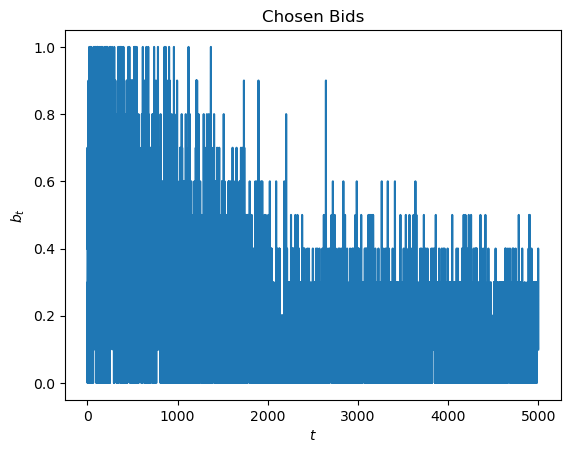

In [20]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

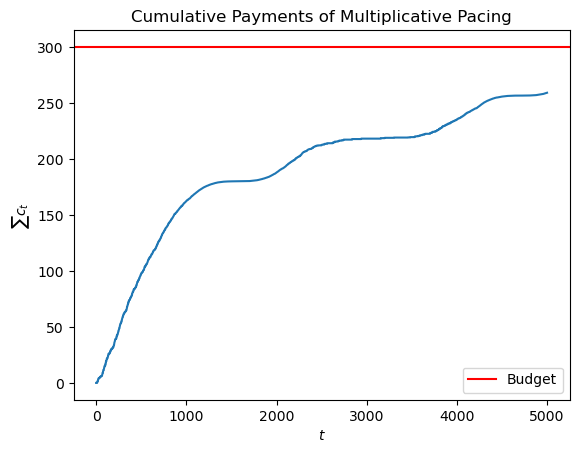

In [21]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

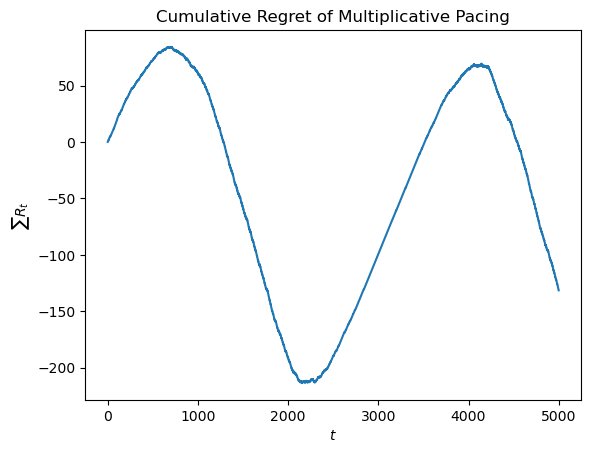

In [22]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

# rework the clairvoyant to better the regret (or try something)

## now doing multiple rounds to have a better idea

In [25]:
n_epochs = 50
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = FirstPriceAuction(np.ones(n_advertisers+1))
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

graphical representation

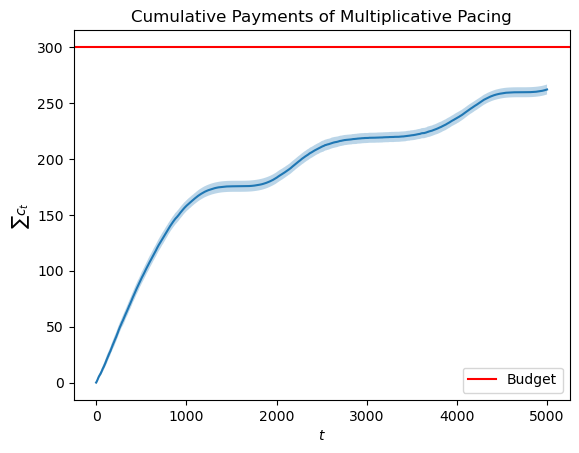

In [26]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

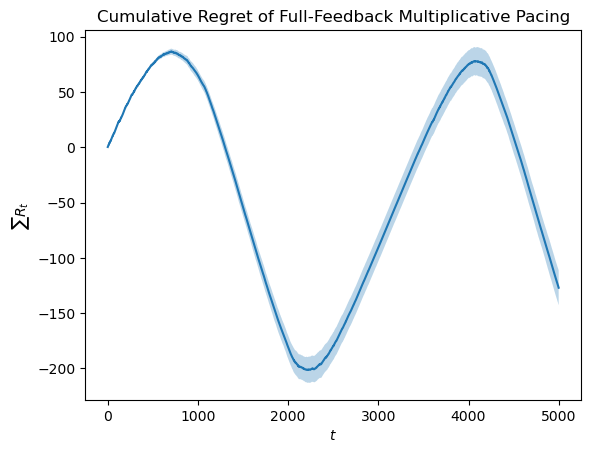

In [27]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

# will have to work ont the regret